# Mapping sales of turkish dolmas

This is a sample on creating a simple map using geopandas. Most of the tricky stuff is in getting the mappign to the shape file right. You can easily extend this to make subplots by another dimension.

For more detailed explanation, see: 

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import shapely as shp
from shapely.geometry import Point
sys.path.append("..")

import mcdata.src.libraries.utils as utl

from mcdata.src.Classes.Tourism import TourismData
from tqdm import tqdm_notebook as tqdm
from statsmodels.formula.api import ols
from shapely.geometry import Point

In [4]:
FIGPATH = "./figures/maps/"
SHP_FILEPATH = "/nfs/home/S/sravinutala/shared_space/ci3_mastercard_bigdata/country_extracts/shapefiles/TUR/"  

## Load files

In [5]:
dolma_data = pd.read_csv("/nfs/home/S/sravinutala/shared_space/cidgrowlab/Sid/tmp/dolma_sales.csv")

In [6]:
dolma_data['coordinates'] = dolma_data[['latitude','longitude']].apply(lambda x: Point(x[1], x[0]), axis=1)

In [7]:
geo_df = gpd.read_file(SHP_FILEPATH + "TUR_adm2.shp")
geomap_gpd = gpd.GeoDataFrame(dolma_data, geometry=dolma_data.coordinates)
gdf = gpd.sjoin(geo_df, geomap_gpd, op='contains', how='left')

In [8]:
gdf.crs = {'init' :'epsg:3395'}

In [9]:
gpd_joined_gby = gdf.groupby(["ID_0", "ID_1", "ID_2"])[["num_dolma"]].sum().reset_index()
gpd_joined_unique = gdf.drop_duplicates(subset = ["ID_0", "ID_1", "ID_2"]).drop("num_dolma", 1)
gpd_joined_gby = gpd_joined_unique.merge(gpd_joined_gby, on = ["ID_0", "ID_1", "ID_2"])

(Optional) Transform your data

In [10]:
x_min = gpd_joined_gby.loc[gpd_joined_gby["num_dolma"] > 0,"num_dolma"].min()
gpd_joined_gby['num_dolma'] = gpd_joined_gby["num_dolma"].apply(lambda x: utl.modlog(x, x_min))

## Setup for plot

### figure (hehe) out dimensions of plot

In [11]:
xmin = gpd_joined_gby.bounds.minx.min()
xmax = gpd_joined_gby.bounds.maxx.max()

ymin = gpd_joined_gby.bounds.miny.min()
ymax = gpd_joined_gby.bounds.maxy.max()

In [12]:
xscale = 20
yscale = (ymax - ymin) * 1.2 * xscale / (xmax - xmin) 

### Get scale for colormap

In [13]:
dolma_max = np.ceil(gpd_joined_gby.num_dolma.max())
dolma_min = np.floor(gpd_joined_gby.num_dolma.min())  

### Get subplot of differing dimensions

In [14]:
buffer = 0.05        # the space between the subplot
xomit = 0.07         # for the scale
yomit = 0.07         # for the header

xmax = 1 - xomit    
ymax = 1 - yomit     

xwidth = xmax
ywidth = ymax

dims = []
dims.append([buffer, buffer, xmax - buffer, ymax - buffer]) # Actual plot
dims.append([xmax, buffer + (ymax - 0.5)/2, xomit - buffer, 0.5 ]) # For the scale
dims.append([buffer, ymax + buffer/2 , xmax - buffer, yomit - buffer]) # For the title

## Lets plot!

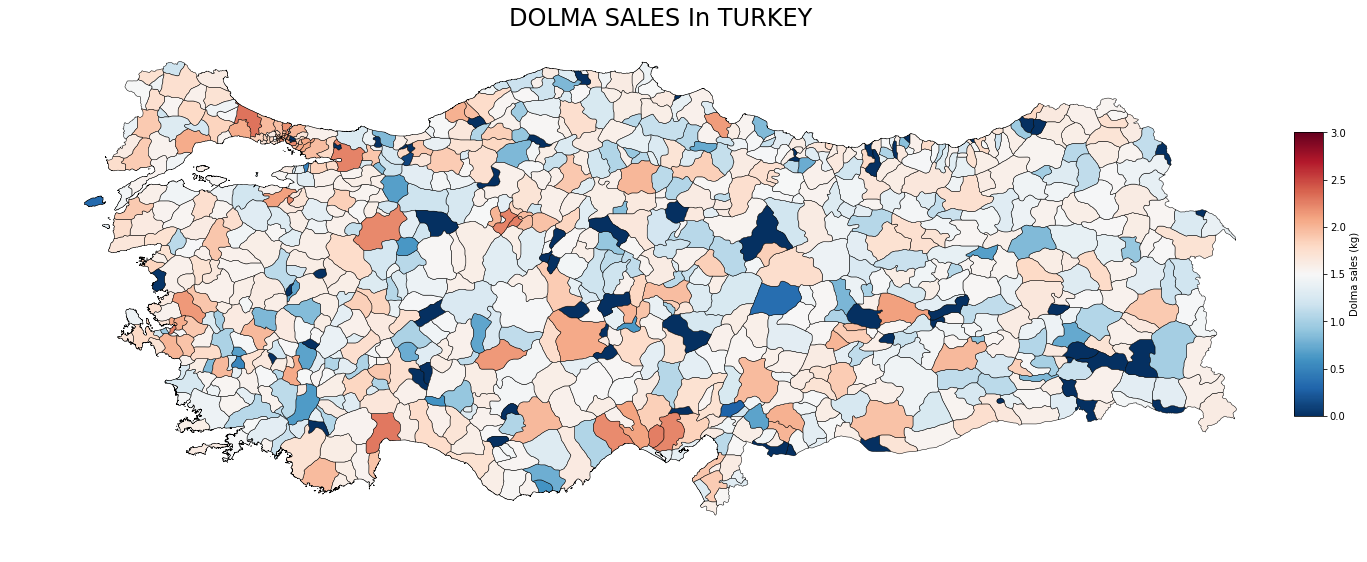

In [16]:
f = plt.figure(figsize=(xscale, yscale))
ax = plt.axes(dims[0])
gpd_joined_gby.plot(column = 'num_dolma', cmap = "RdBu_r", vmin = dolma_min, vmax = dolma_max, legend = False, figsize=(xscale,yscale),
                         linewidth = 0.5, edgecolor='black', ax = ax)
ax.axis("off")  

cax = plt.axes(dims[-2])
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=dolma_min, vmax = dolma_max)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label("Dolma sales (kg)")

ax = plt.axes(dims[-1])
ax.annotate("DOLMA SALES In TURKEY", xy = (0.5, 0.5), ha="center", va="center", fontsize = 24)
ax.axis("off")

plt.savefig(FIGPATH + "XX_TUR_dolmas.png")